# Neural Networks with PyTorch

## Notebook Objectives

In this notebook we are going to implement and train a neural network with PyTorch!

In [1]:
import torch
from matplotlib.pyplot import axes
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import trange

# Visualization
This block defines helper functions to visualize images, predictions, and confusion matrices. These functions make it easier to interpret model results and identify where the model is performing well or struggling.

In [2]:
# @title plotting functions

from matplotlib import pyplot as plt

def visualize(images, labels):
    """
    Visualize a batch of images.
    """
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def visualize_predictions(images, labels, predicted_labels):
    """
    Visualize a batch of images with their true and predicted labels.
    Titles are green if the prediction is correct, red if incorrect.
    """
    fig, axes = plt.subplots(8, 8, figsize=(11, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')
        color = 'green' if labels[i].item() == predicted_labels[i].item() else 'red'
        ax.set_title(f'True: {labels[i].item()}\nPred: {predicted_labels[i].item()}', color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_conf_mat(model, dataloader, device):
    """
    Plot the confusion matrix for a given model and dataloader.
    """
    # Initialize the confusion matrix
    total, correct = 0, 0
    conf_mat = torch.zeros((10, 10))
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total += pred.shape[0]
            pred = torch.argmax(pred, axis=1)
            correct += sum(pred == y).item()
            for j in range(pred.shape[0]):
                conf_mat[y[j], pred[j].item()] += 1
    # calculate the normalized confusion matrix
    norm_conf_mat = conf_mat / torch.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(10))
    plt.yticks(range(10))
    plt.colorbar()
    # put number of each cell in plot
    for i in range(10):
        for j in range(10):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()


## DataSets
loads the MNIST dataset (images of handwritten digits 0–9) using `torchvision.datasets`. It prepares two separate datasets: one for training (60,000 images) and one for testing (10,000 images). Each image is automatically converted into a PyTorch tensor with pixel values normalized between 0 and

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(f"training_data: {training_data}")
print(f"test_data: {test_data}")

training_data: Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Data Loaders
uses PyTorch DataLoader to prepare the MNIST dataset for training and testing. Instead of loading all 60,000 training images or 10,000 test images at once, the data is split into mini-batches of size 64. Mini-batching speeds up training and allows processing on GPUs efficiently.

In [4]:
batch_size = 64
train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

for x, y in test_loader:
    print(f"shape of x: {x.shape}")
    print(f"shape of y: {y.shape} {y.dtype}")
    break

shape of x: torch.Size([64, 1, 28, 28])
shape of y: torch.Size([64]) torch.int64


## Visualization
 get one batch from the DataLoader and visualizing it

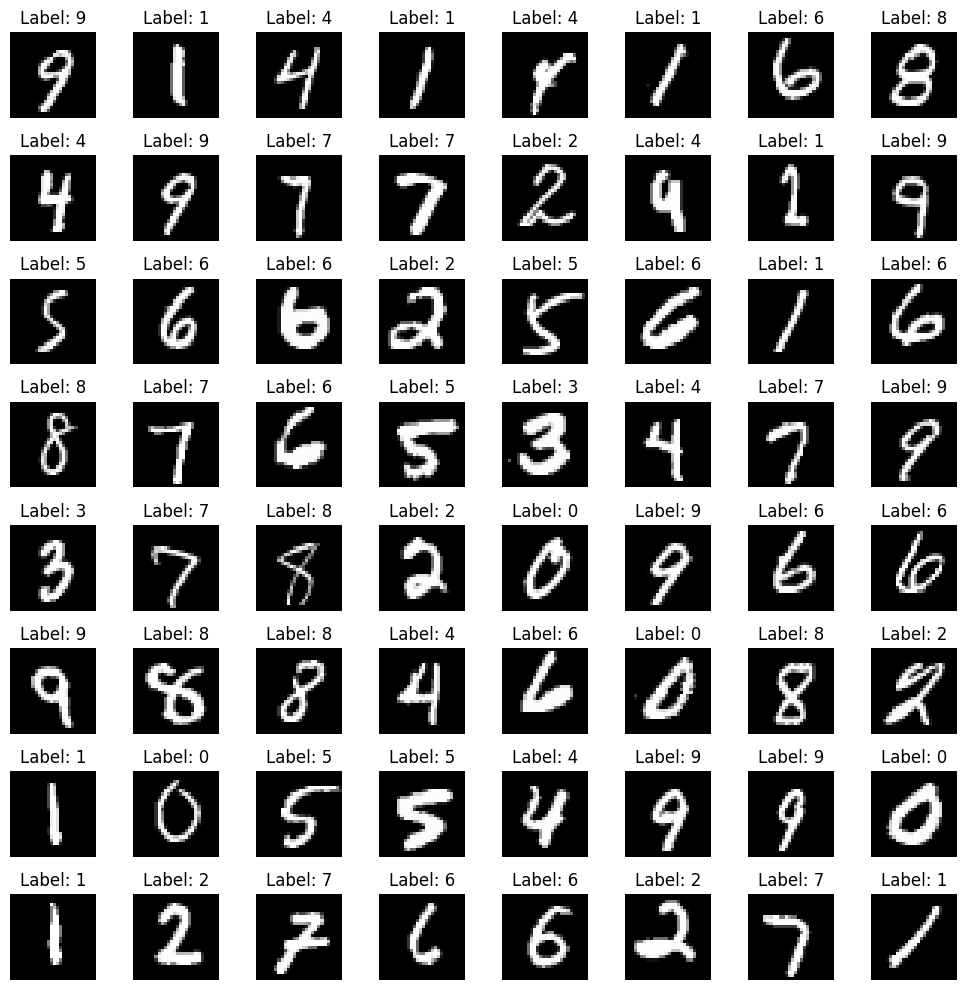

In [5]:
images, labels = next(iter(train_loader))
visualize(images, labels)

## Device
To accelerate operations in the neural network, we move it to the GPU or MPS (for Apple silicon) if available.


In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu")
print(f"using device: {device}")

using device: cpu


## Model
defines a fully connected feedforward neural network for classifying MNIST digits. The model takes a 28×28 grayscale image, flattens it into a 1D vector, and passes it through two hidden layers with ReLU activations before producing 10 output scores (logits) — one for each digit (0–9).

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Initialize our model
instantiating our neural network model and moving it to the chosen device (CPU, CUDA GPU, or Apple MPS GPU)

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Loss Function
Since we are trying to classify the handwritten digits, we are going to use the cross entropy loss.


In [9]:
loss_fn = nn.CrossEntropyLoss()

## Optimizer
Next we need to setup an optimizer for training our model. We use stochastic gradient descent so we have must use the `SGD` module from `torch.optim`. We must pass the `model.parameters()` to the `SGD` optimizer and set its learning rate `lr=1e-3`.


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Training
To train the model we first set the number of epochs. For each epoch we then iterate over the entire training data and update the model parameters. For each batch of data, we must first move the data to same device as the network, then we predict the output of the model, calculate the loss, perform backward pass, update parameters, and reset the gradients.

To monitor training, we use `trange` from `tqdm` which performs similar to `range` but allows us to have a progress bar `pbar` which lets us display useful information.


In [11]:
n_epochs = 30

for _ in (pbar := trange(n_epochs)):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Loss = {loss.item():.3f}')


Loss = 0.442: 100%|██████████| 30/30 [03:17<00:00,  6.57s/it]


## Evaluation
Finally we can evaluate the trained model. We will start by evaluating the model on the test dataset. Here we use `torch.no_grad()` since we don't need the gradients. We iterate over the entire test dataset and print the accuracy of our model on this dataset.


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logist = model(x)
        pred = torch.argmax(logist, axis=1)
        correct += (pred == y).sum().item()
        total += pred.shape[0]
        print(f"Accuracy: {100* correct / total:.2f}%")

Accuracy: 95.31%
Accuracy: 94.53%
Accuracy: 94.79%
Accuracy: 92.19%
Accuracy: 90.31%
Accuracy: 90.10%
Accuracy: 90.40%
Accuracy: 90.43%
Accuracy: 90.97%
Accuracy: 90.16%
Accuracy: 89.77%
Accuracy: 89.71%
Accuracy: 89.78%
Accuracy: 90.07%
Accuracy: 90.42%
Accuracy: 90.43%
Accuracy: 89.98%
Accuracy: 89.58%
Accuracy: 89.39%
Accuracy: 89.69%
Accuracy: 89.96%
Accuracy: 90.20%
Accuracy: 90.42%
Accuracy: 90.43%
Accuracy: 90.50%
Accuracy: 90.20%
Accuracy: 90.16%
Accuracy: 90.07%
Accuracy: 90.25%
Accuracy: 90.05%
Accuracy: 90.02%
Accuracy: 89.94%
Accuracy: 90.01%
Accuracy: 90.07%
Accuracy: 90.13%
Accuracy: 90.02%
Accuracy: 90.08%
Accuracy: 90.05%
Accuracy: 89.98%
Accuracy: 89.96%
Accuracy: 90.05%
Accuracy: 90.14%
Accuracy: 90.15%
Accuracy: 89.99%
Accuracy: 90.00%
Accuracy: 90.01%
Accuracy: 90.13%
Accuracy: 90.01%
Accuracy: 90.08%
Accuracy: 90.06%
Accuracy: 90.07%
Accuracy: 90.14%
Accuracy: 90.09%
Accuracy: 90.08%
Accuracy: 90.03%
Accuracy: 90.15%
Accuracy: 90.05%
Accuracy: 90.09%
Accuracy: 90.0

## visualize
Let's visuzlie a batch to compare the predictions and the true labels.

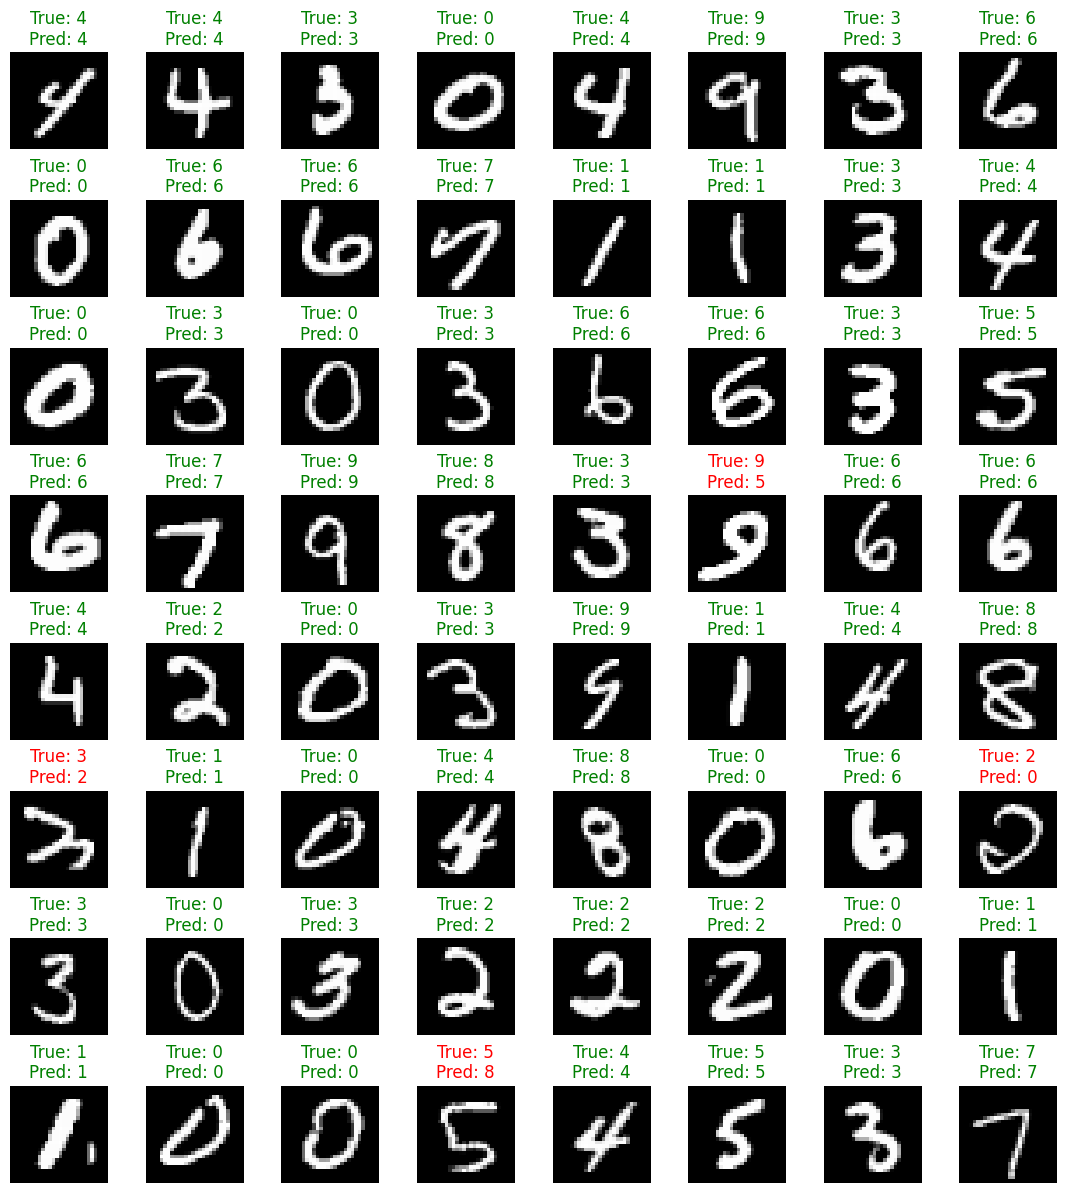

In [13]:
images, labels = next(iter(test_loader))
preds = torch.argmax(model(images).to(device), axis=1).cpu()
visualize_predictions(images, labels, preds)

Plot as confusion matrix

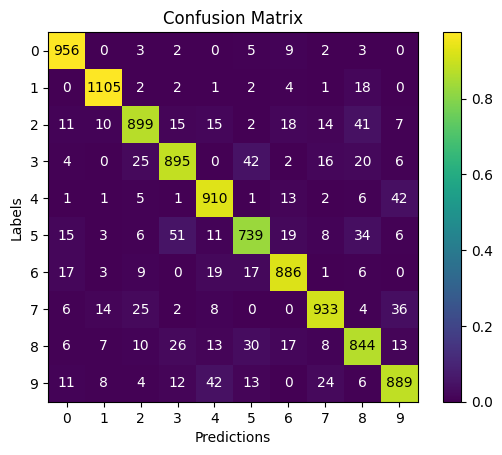

In [14]:
plot_conf_mat(model, test_loader, device)

## Different Optimizer
Here we will take a look at different optimizers and how they effect training and convergence. Run the widget bellow to train the model for different optimizers! You can increase the number of epochs or set the hyperparameters of each optimizers manually if you like.



In [20]:
import ipywidgets as widgets
from IPython.display import display

training_data = DataLoader(training_data, batch_size = 128)
def train_model(model, optimizer, n_epochs):
    losses, accuracies = [], []
    for _ in (pbar := trange(n_epochs)):
        running_loss ,acc = 0, 0
        for x, y in training_data:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += (pred == y).sum().item()
        acc /= len(training_data.dataset)
        acc*=100
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies

def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
         continue
        losses, accuracies = res['losses'], res['accuracies']
        axes[0].plot(losses, labels=optimizer)
        axes[1].plot(accuracies, labels=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()


options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

dropdown = widgets.Dropdown(
    options=options,
    description='optimizer',
    layout = {'width' :'200px'},
    style = {'description_width': 'initial'},
)

# Define a function to run based on selected value
def on_change_value(change):
    optimizer = change['new']
    global first_run, results
    model = NeuralNetwork().to(device)
    if results[optimizer] != {} :
        losses, accuracies = results[optimizer]
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer] = losses, accuracies
    plot_losses_accuracies(results)

# Observe changes in the dropdown value
dropdown.observe(on_change_value, names='value')

results = {optimizer: dict() for optimizer in options}

#on_change_value({"new": 'SGD'})

# Display the widget
display(dropdown)


Dropdown(description='optimizer', layout=Layout(width='200px'), options=('SGD', 'AdaGrad', 'RMSProp', 'Adam'),…